In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import statistics
import pickle
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Activation, Dropout, Reshape
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling1D, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Sequential  # Corrected import
from tensorflow.keras.layers import TimeDistributed, LSTM
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split  # Corrected import
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ProjectSwinburne1/undamaged4.csv
/kaggle/input/ProjectSwinburne1/undamaged2.csv
/kaggle/input/ProjectSwinburne1/undamaged5.csv
/kaggle/input/ProjectSwinburne1/damaged5.csv
/kaggle/input/ProjectSwinburne1/damaged2.csv
/kaggle/input/ProjectSwinburne1/undamaged3.csv
/kaggle/input/ProjectSwinburne1/damaged1.csv
/kaggle/input/ProjectSwinburne1/damaged4.csv
/kaggle/input/ProjectSwinburne1/damaged3.csv
/kaggle/input/ProjectSwinburne1/cnn_lstm.ipynb
/kaggle/input/ProjectSwinburne1/undamaged1.csv


In [3]:
def load_and_combine_csv(file_list):
    dataframes = [pd.read_csv(file) for file in file_list]
    return pd.concat(dataframes, ignore_index=True)

In [4]:
damaged_files = ['/kaggle/input/ProjectSwinburne1/damaged1.csv', 
           '/kaggle/input/ProjectSwinburne1/damaged2.csv',
          '/kaggle/input/ProjectSwinburne1/damaged3.csv',
           '/kaggle/input/ProjectSwinburne1/damaged4.csv',
          '/kaggle/input/ProjectSwinburne1/damaged5.csv']
undamaged_files = ['/kaggle/input/ProjectSwinburne1/undamaged1.csv',
            '/kaggle/input/ProjectSwinburne1/undamaged2.csv',
            '/kaggle/input/ProjectSwinburne1/undamaged3.csv',
            '/kaggle/input/ProjectSwinburne1/undamaged4.csv',
            '/kaggle/input/ProjectSwinburne1/undamaged5.csv']

df_damaged = load_and_combine_csv(damaged_files)
df_undamaged = load_and_combine_csv(undamaged_files)

In [5]:
# Giữ lại 80 cột đầu tiên trong cả hai tập dữ liệu
num_common_sensors = 80
df_damaged = df_damaged.iloc[:, :num_common_sensors]
df_undamaged = df_undamaged.iloc[:, :num_common_sensors]

# Xử lý NaN và giá trị không hợp lệ
def clean_data(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)
    return df

df_damaged = clean_data(df_damaged)
df_undamaged = clean_data(df_undamaged)

In [6]:
def save_to_file(X, y, filename):
    np.savez_compressed(filename, X=X, y=y)
    print(f"Data saved to {filename}.npz")

# def prepare_cnn_data_raw(df_damaged, df_undamaged, timesteps=10):
#def prepare_cnn_data_raw(df_damaged, df_undamaged, timesteps=15):
def prepare_cnn_data_raw(df_damaged, df_undamaged, timesteps=20):
    X = np.concatenate([df_damaged.values, df_undamaged.values], axis=0)
    y = np.concatenate([np.ones(len(df_damaged)), np.zeros(len(df_undamaged))])

    # Ensure even division by timesteps
    num_samples = X.shape[0] // timesteps
    X = X[:num_samples * timesteps].reshape(num_samples, timesteps, X.shape[1])
    y = y[:num_samples * timesteps:timesteps]  # Select one label per sequence

    return X, y

# Prepare the raw data for CNN training
X_cnn, y_cnn = prepare_cnn_data_raw(df_damaged, df_undamaged)

In [7]:
# Split off 10% for test set 
X_temp, X_test_real, y_temp, y_test_real = train_test_split(
    X_cnn, y_cnn, test_size=0.1, random_state=42, stratify=y_cnn
)

# 80-20 split on the remaining 90%
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# Scale X_train and X_test (not X_test_real)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

#scale X_test_real 
X_test_real = scaler.transform(X_test_real.reshape(-1, X_test_real.shape[-1])).reshape(X_test_real.shape)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization,
    Bidirectional, LSTM, Dense, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

print("========================== CNN + BiLSTM (Residual) =====================")

input_layer = Input(shape=(20, 80), name='input')

# First CNN Block
x1 = Conv1D(64, kernel_size=5, activation='relu', padding='same', name='conv1')(input_layer)
x1 = BatchNormalization(name='bn1')(x1)
x1 = MaxPooling1D(pool_size=2, name='pool1')(x1)
x1 = Dropout(0.3, name='drop1')(x1)

# Second CNN Block
x2 = Conv1D(64, kernel_size=3, activation='relu', padding='same', name='conv2')(x1)
x2 = BatchNormalization(name='bn2')(x2)
x2 = MaxPooling1D(pool_size=2, name='pool2')(x2)
x2 = Dropout(0.3, name='drop2')(x2)

# Residual connection (match filters and shape)
residual = Conv1D(64, kernel_size=1, padding='same', name='res_conv')(x1)
residual = MaxPooling1D(pool_size=2, name='res_pool')(residual)
x = Add(name='res_add')([x2, residual])

# Third CNN Block
x = Conv1D(256, kernel_size=3, activation='relu', padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = MaxPooling1D(pool_size=2, name='pool3')(x)
x = Dropout(0.3, name='drop3')(x)

# BiLSTM Stack
x = Bidirectional(LSTM(256, return_sequences=True), name='bilstm1')(x)
x = Bidirectional(LSTM(128, return_sequences=True), name='bilstm2')(x)
x = Bidirectional(LSTM(64, return_sequences=False), name='bilstm3')(x)

# Dense Classification Head
x = Dense(64, activation='relu', name='fc1')(x)
x = Dropout(0.5, name='drop_final')(x)
output = Dense(1, activation='sigmoid', name='output')(x)

model = Model(inputs=input_layer, outputs=output, name='ResidualModel')

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class distribution in training set:", class_counts)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[reduce_lr]
)

model.save_weights('residual_model.weights.h5')


========================== CNN + BiLSTM (Residual) =====================


Model: "ResidualModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 20, 80)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv1D)            │ (None, 20, 64)         │         25,664 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn1 (BatchNormalization)  │ (None, 20, 64)         │            256 │ conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling1D)      │ (None, 10, 64)         │              0 │ bn1[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop1 (Dropout)           │ (None, 10, 64)         │              0 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2 (Conv1D)            │ (None, 10, 64)         │         12,352 │ drop1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2 (BatchNormalization)  │ (None, 10, 64)         │            256 │ conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling1D)      │ (None, 5, 64)          │              0 │ bn2[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_conv (Conv1D)         │ (None, 10, 64)         │          4,160 │ drop1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop2 (Dropout)           │ (None, 5, 64)          │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_pool (MaxPooling1D)   │ (None, 5, 64)          │              0 │ res_conv[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_add (Add)             │ (None, 5, 64)          │              0 │ drop2[0][0],           │
│                           │                        │                │ res_pool[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3 (Conv1D)            │ (None, 5, 256)         │         49,408 │ res_add[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn3 (BatchNormalization)  │ (None, 5, 256)         │          1,024 │ conv3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool3 (MaxPooling1D)      │ (None, 2, 256)         │              0 │ bn3[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ drop3 (Dropout)           │ (None, 2, 256)         │              0 │ pool3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bilstm1 (Bidirectional)   │ (None, 2, 512)         │      1,050,624 │ drop3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bilstm2 (Bidirectional)   │ (None, 2, 256)         │        656,384 │ bilstm1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bilstm3 (Bidirectional)   │ (None, 128)            │        164,352 │ bilstm2[0][0]          │
├──────────────────────

 Total params: 1,972,801 (7.53 MB)

 Trainable params: 1,972,033 (7.52 MB)

 Non-trainable params: 768 (3.00 KB)

Class distribution in training set: {0.0: 1474, 1.0: 1474}
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.7156 - loss: 0.4774 - precision: 0.7510 - recall: 0.6216 - val_accuracy: 0.9159 - val_loss: 0.1175 - val_precision: 0.8561 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9063 - loss: 0.1439 - precision: 0.9093 - recall: 0.9105 - val_accuracy: 0.9159 - val_loss: 0.1187 - val_precision: 1.0000 - val_recall: 0.8320 - learning_rate: 0.0010
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9213 - loss: 0.1280 - precision: 0.9491 - recall: 0.8998 - val_accuracy: 0.9240 - val_loss: 0.1131 - val_precision: 0.8682 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9395 - loss: 0.1102 - precision: 0.9106 - recall: 0.9758 - val_accuracy: 0.9769 - val_loss: 0.0639 - val_precision: 0.9809 - val_recall: 0.9729 - learning_rate: 0.0010
Epoc

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization,
    Bidirectional, LSTM, Dense, Attention, GlobalAveragePooling1D,
    Reshape, Flatten, Add
)


def build_residual_model():
    input_layer = Input(shape=(20, 80), name='input')

    # First CNN Block
    x1 = Conv1D(64, kernel_size=5, activation='relu', padding='same', name='conv1')(input_layer)
    x1 = BatchNormalization(name='bn1')(x1)
    x1 = MaxPooling1D(pool_size=2, name='pool1')(x1)
    x1 = Dropout(0.3, name='drop1')(x1)

    # Second CNN Block
    x2 = Conv1D(64, kernel_size=3, activation='relu', padding='same', name='conv2')(x1)
    x2 = BatchNormalization(name='bn2')(x2)
    x2 = MaxPooling1D(pool_size=2, name='pool2')(x2)
    x2 = Dropout(0.3, name='drop2')(x2)

    # Residual connection
    residual = Conv1D(64, kernel_size=1, padding='same', name='res_conv')(x1)
    residual = MaxPooling1D(pool_size=2, name='res_pool')(residual)
    x = Add(name='res_add')([x2, residual])

    # Third CNN Block
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = MaxPooling1D(pool_size=2, name='pool3')(x)
    x = Dropout(0.3, name='drop3')(x)

    # BiLSTM Stack
    x = Bidirectional(LSTM(256, return_sequences=True), name='bilstm1')(x)
    x = Bidirectional(LSTM(128, return_sequences=True), name='bilstm2')(x)
    x = Bidirectional(LSTM(64, return_sequences=False), name='bilstm3')(x)

    # Dense
    x = Dense(64, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='drop_final')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)

    return Model(inputs=input_layer, outputs=output, name='ResidualModel')


def build_attention_model():
    input_layer = Input(shape=(20, 80), name='input')

    # CNN Layers (same names for weight transfer)
    x = Conv1D(64, kernel_size=5, activation='relu', padding='same', name='conv1')(input_layer)
    x = BatchNormalization(name='bn1')(x)
    x = MaxPooling1D(pool_size=2, name='pool1')(x)
    x = Dropout(0.3, name='drop1')(x)

    x = Conv1D(128, kernel_size=3, activation='relu', padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = MaxPooling1D(pool_size=2, name='pool2')(x)
    x = Dropout(0.3, name='drop2')(x)

    x = Conv1D(256, kernel_size=3, activation='relu', padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = MaxPooling1D(pool_size=2, name='pool3')(x)
    x = Dropout(0.3, name='drop3')(x)

    # BiLSTM (only 1 layer to match naming)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True), name='bilstm1')(x)

    # Temporal Attention
    query = GlobalAveragePooling1D(name='attn_pool')(lstm_out)
    query = Reshape((1, 256), name='attn_query_reshape')(query)
    context = Attention(name='temporal_attention')([query, lstm_out])
    context = Flatten(name='attn_flatten')(context)

    # Dense Layers
    x = Dense(64, activation='relu', name='fc1')(context)
    x = Dropout(0.5, name='drop_final')(x)
    output = Dense(1, activation='sigmoid', name='output')(x)

    return Model(inputs=input_layer, outputs=output, name='TemporalAttentionModel')


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Exclude the real test set 
X_cnn_temp, y_cnn_temp = X_temp, y_temp  # These are the data left after splitting off 10% real test set

# Scale the full dataset (excluding test_real)
scaler = StandardScaler()
X_cnn_temp = scaler.fit_transform(X_cnn_temp.reshape(-1, X_cnn_temp.shape[-1])).reshape(X_cnn_temp.shape)

# Cross-validation setup with 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores, f1_scores, prec_scores, rec_scores = [], [], [], []
histories_att = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_cnn_temp, y_cnn_temp), 1):
    print(f"\n================ Fold {fold} - Attention Model ================")

    # Split the training and validation sets based on the fold
    X_train, X_val = X_cnn_temp[train_idx], X_cnn_temp[val_idx]
    y_train, y_val = y_cnn_temp[train_idx], y_cnn_temp[val_idx]

    # Build the model and load pre-trained weights
    model_att = build_attention_model()
    pretrained_res = build_residual_model()
    pretrained_res.load_weights("residual_model.weights.h5")

    # Transfer weights from residual model
    for layer in model_att.layers:
        try:
            pretrained_layer = pretrained_res.get_layer(name=layer.name)
            layer.set_weights(pretrained_layer.get_weights())
        except:
            pass

    checkpoint = ModelCheckpoint(
        filepath=f'attention_model_fold{fold}_epoch{{epoch:02d}}_valloss{{val_loss:.4f}}_valacc{{val_accuracy:.4f}}.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-5,
        verbose=1
    )

    model_att.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    history = model_att.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[reduce_lr, checkpoint],
        verbose=1
    )

    histories_att.append(history)

    y_pred = (model_att.predict(X_val) > 0.5).astype(int)

    acc_scores.append(accuracy_score(y_val, y_pred))
    f1_scores.append(f1_score(y_val, y_pred))
    prec_scores.append(precision_score(y_val, y_pred))
    rec_scores.append(recall_score(y_val, y_pred))

print(f"Accuracy Scores: {acc_scores}")
print(f"F1 Scores: {f1_scores}")
print(f"Precision Scores: {prec_scores}")
print(f"Recall Scores: {rec_scores}")


================ Fold 1 - Attention Model ================
Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9008 - loss: 0.2622 - precision_1: 0.9096 - recall_1: 0.8793
Epoch 1: val_loss improved from inf to 0.12162, saving model to attention_model_fold1_epoch01_valloss0.1216_valacc0.9973.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9017 - loss: 0.2598 - precision_1: 0.9105 - recall_1: 0.8806 - val_accuracy: 0.9973 - val_loss: 0.1216 - val_precision_1: 1.0000 - val_recall_1: 0.9946 - learning_rate: 0.0010
Epoch 2/100
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9868 - loss: 0.0357 - precision_1: 0.9886 - recall_1: 0.9855
Epoch 2: val_loss improved from 0.12162 to 0.02869, saving model to attention_model_fold1_epoch02_valloss0.0287_valacc0.9973.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9867 - loss: 0.0359 - precision_1: 0.9886 - recall_1: 0.9854 - val_accuracy: 0.9973 - val_loss: 0.0287 - val_precision_1: 1.0000 - val_recall_1:

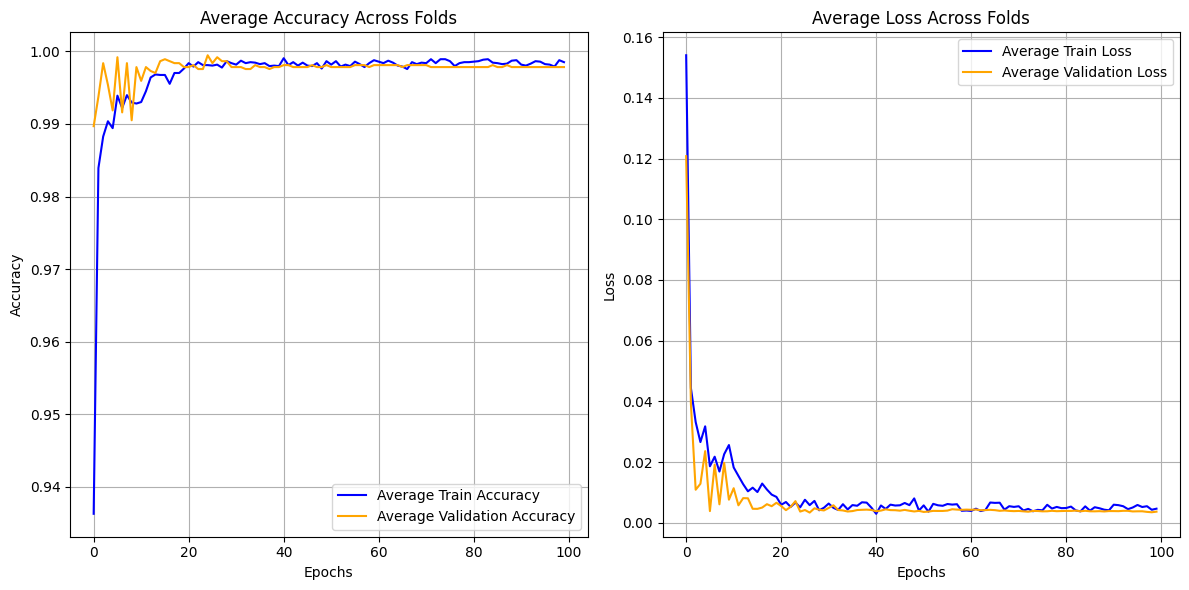

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# lists to hold all accuracies and losses across folds
all_train_accuracy = []
all_val_accuracy = []
all_train_loss = []
all_val_loss = []

# Loop through each fold history and aggregate
for history in histories_att:
    all_train_accuracy.append(history.history['accuracy'])
    all_val_accuracy.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

# Convert lists to numpy arrays 
all_train_accuracy = np.array(all_train_accuracy)
all_val_accuracy = np.array(all_val_accuracy)
all_train_loss = np.array(all_train_loss)
all_val_loss = np.array(all_val_loss)

plt.figure(figsize=(12, 6))

#Average Accuracy
plt.subplot(1, 2, 1)
plt.plot(np.mean(all_train_accuracy, axis=0), label='Average Train Accuracy', color='blue')
plt.plot(np.mean(all_val_accuracy, axis=0), label='Average Validation Accuracy', color='orange')
plt.title('Average Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

#Average Loss
plt.subplot(1, 2, 2)
plt.plot(np.mean(all_train_loss, axis=0), label='Average Train Loss', color='blue')
plt.plot(np.mean(all_val_loss, axis=0), label='Average Validation Loss', color='orange')
plt.title('Average Loss Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


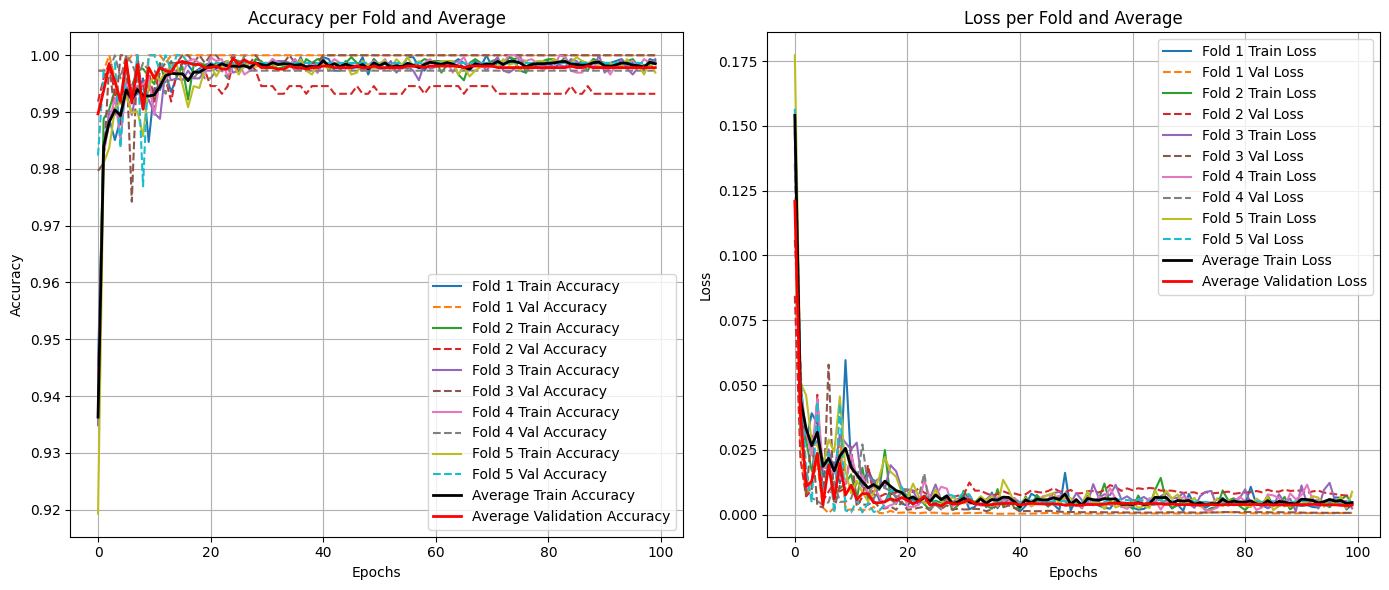

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 6))

#accuracy for each fold
plt.subplot(1, 2, 1)
for i, history in enumerate(histories_att, 1):
    plt.plot(history.history['accuracy'], label=f'Fold {i} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'Fold {i} Val Accuracy', linestyle='--')

#average curve 
plt.plot(np.mean(all_train_accuracy, axis=0), label='Average Train Accuracy', color='black', linewidth=2)
plt.plot(np.mean(all_val_accuracy, axis=0), label='Average Validation Accuracy', color='red', linewidth=2)

plt.title('Accuracy per Fold and Average')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# loss for each fold
plt.subplot(1, 2, 2)
for i, history in enumerate(histories_att, 1):
    plt.plot(history.history['loss'], label=f'Fold {i} Train Loss')
    plt.plot(history.history['val_loss'], label=f'Fold {i} Val Loss', linestyle='--')

# average curve 
plt.plot(np.mean(all_train_loss, axis=0), label='Average Train Loss', color='black', linewidth=2)
plt.plot(np.mean(all_val_loss, axis=0), label='Average Validation Loss', color='red', linewidth=2)

plt.title('Loss per Fold and Average')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


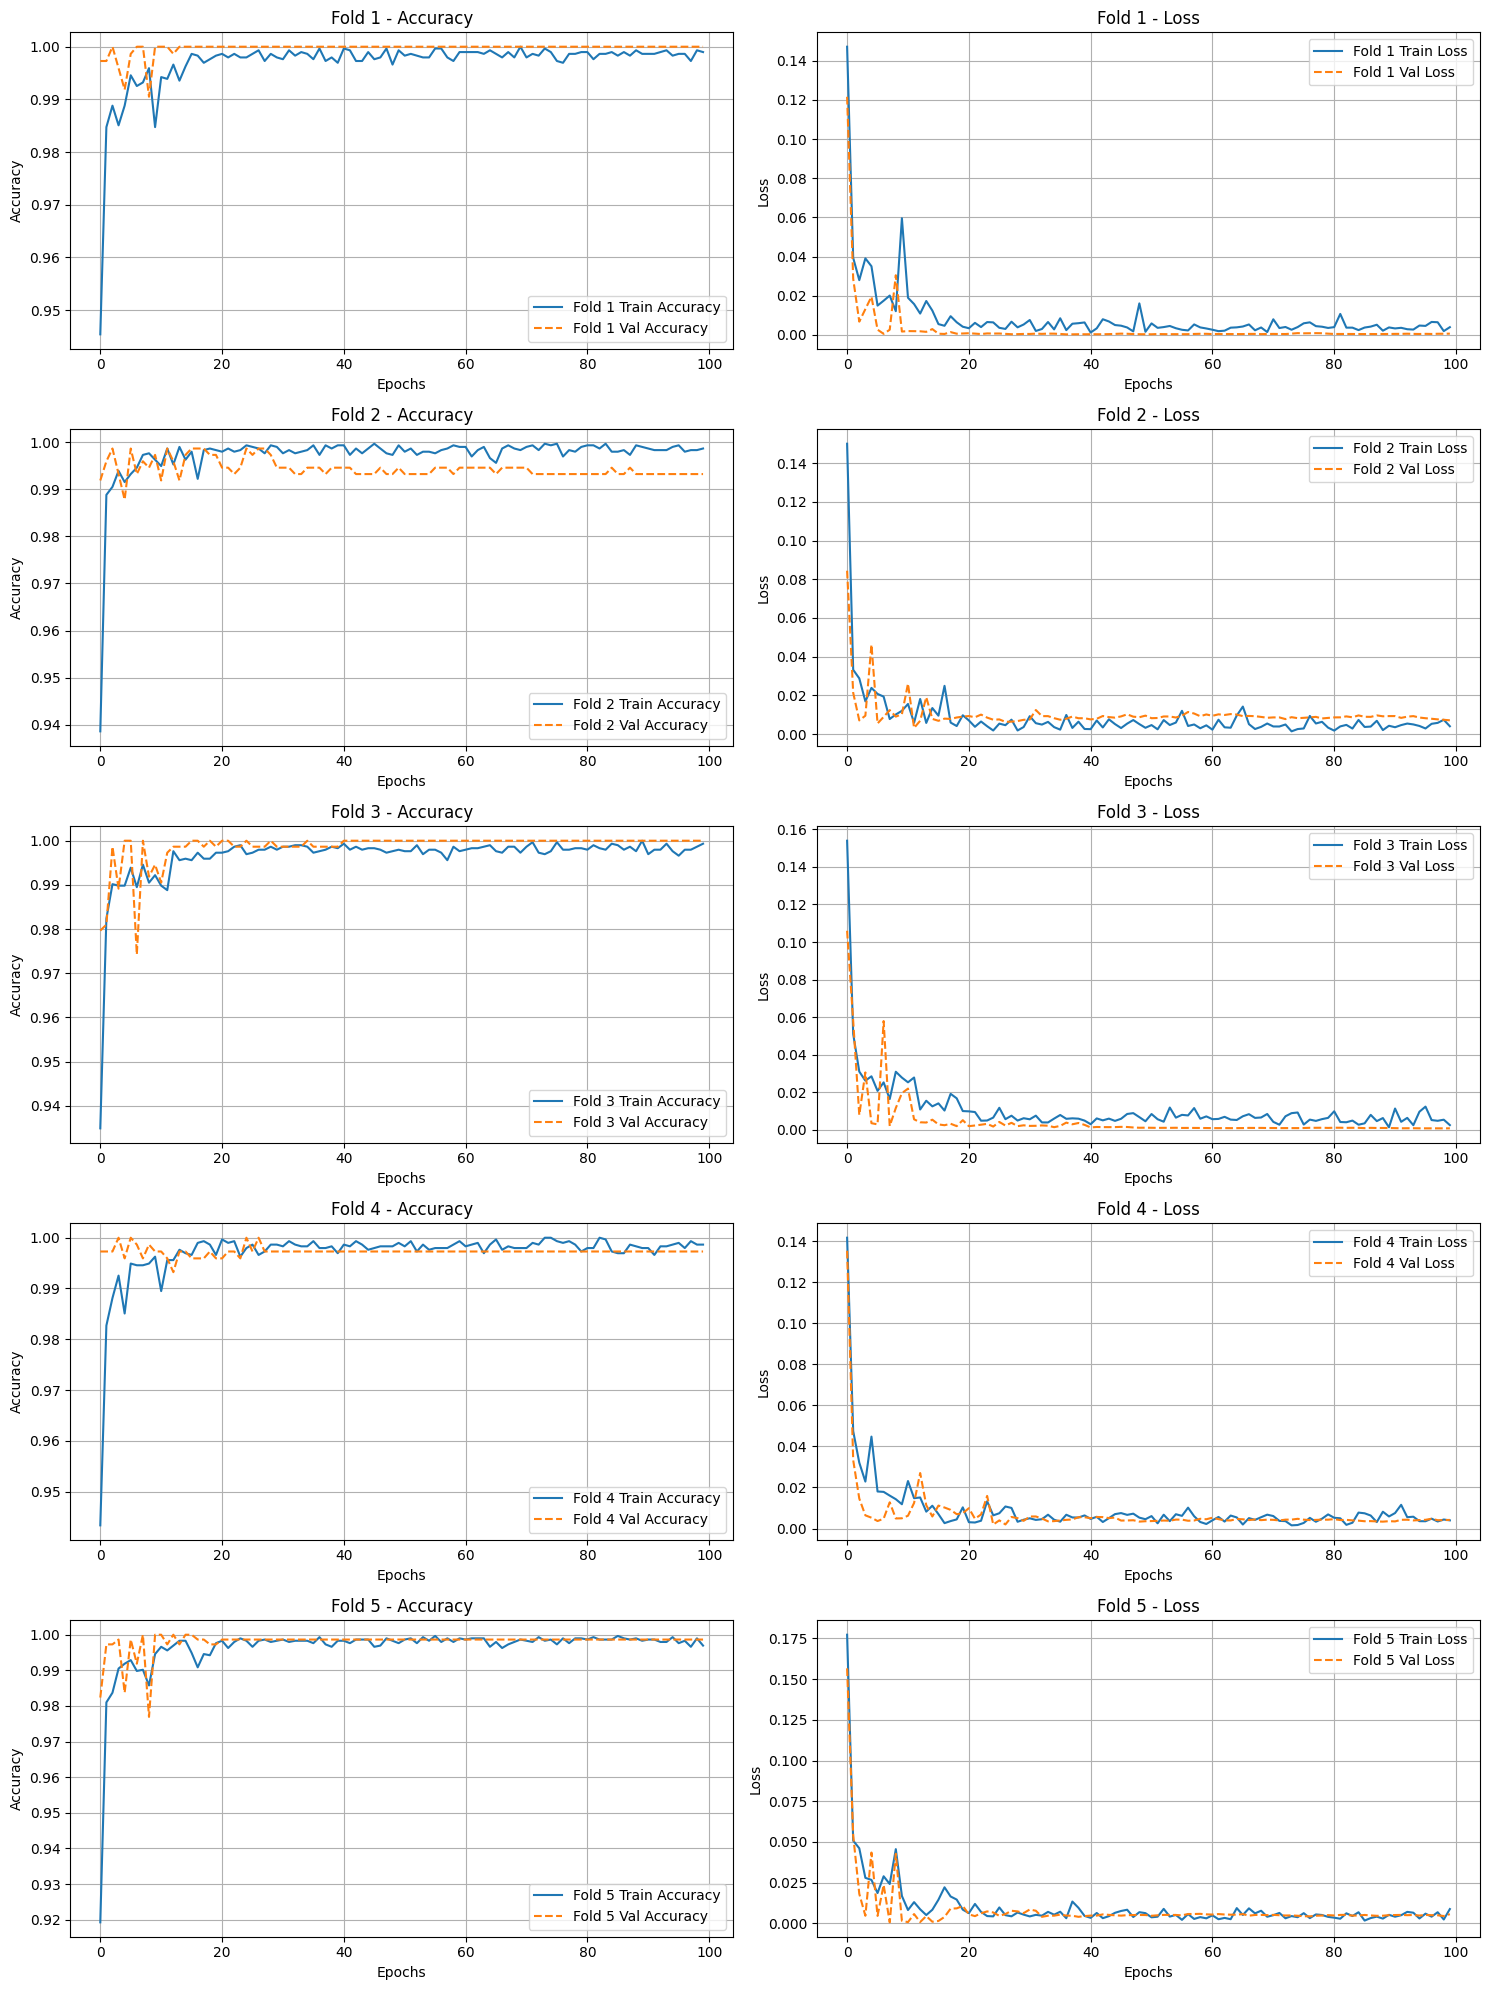

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 20))

# Loop through each fold and create subplots for accuracy and loss
for i, history in enumerate(histories_att, 1):
    # Accuracy plot for the fold
    plt.subplot(5, 2, 2*i-1)  # odd-numbered subplots (1, 3, 5, 7, 9)
    plt.plot(history.history['accuracy'], label=f'Fold {i} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'Fold {i} Val Accuracy', linestyle='--')
    plt.title(f'Fold {i} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot for the fold
    plt.subplot(5, 2, 2*i)  # even-numbered subplots (2, 4, 6, 8, 10)
    plt.plot(history.history['loss'], label=f'Fold {i} Train Loss')
    plt.plot(history.history['val_loss'], label=f'Fold {i} Val Loss', linestyle='--')
    plt.title(f'Fold {i} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


In [14]:
test_loss, test_accuracy, test_precision, test_recall = model_att.evaluate(X_test_real, y_test_real)

print(f"\nTest Loss     : {test_loss:.4f}")
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9927 - loss: 0.0202 - precision_5: 0.9819 - recall_5: 1.0000

Test Loss     : 0.0102
Test Accuracy : 0.9976
Test Precision: 0.9951
Test Recall   : 1.0000


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = (model_att.predict(X_test_real) > 0.5).astype("int32")

print("Classification Report:")
print(classification_report(y_test_real, y_pred, target_names=["Undamaged", "Damaged"]))


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report:
              precision    recall  f1-score   support

   Undamaged       1.00      1.00      1.00       205
     Damaged       1.00      1.00      1.00       205

    accuracy                           1.00       410
   macro avg       1.00      1.00      1.00       410
weighted avg       1.00      1.00      1.00       410



In [16]:
cm = confusion_matrix(y_test_real, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[204   1]
 [  0 205]]


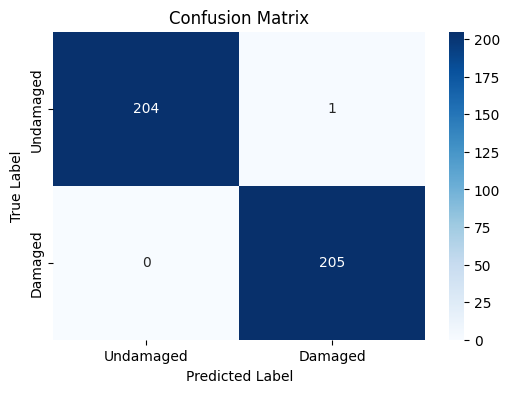

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Undamaged", "Damaged"], yticklabels=["Undamaged", "Damaged"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [18]:
from tensorflow.keras.models import load_model

model = load_model('attention_model_fold5_epoch25_valloss0.0007_valacc1.0000.keras')

model.save('temporal_attention_best.h5')
print("Model successfully saved as temporal_attention_best.h5")

ValueError: File not found: filepath=attention_model_fold5_epoch25_valloss0.0007_valacc1.0000.keras. Please ensure the file is an accessible `.keras` zip file.